In [4]:
import MySQLdb
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
con = MySQLdb.connect(host='localhost', user='root',  db='imdb_movies',                          passwd='bazinga73')
cur = con.cursor()

## Seleção dos Dados

In [6]:
# Atores e filmes ao qual atuaram
atores = cur.execute("select roles.movie_id, concat(actors.first_name, ' ' ,actors.last_name)  from actors inner join roles on roles.actor_id = actors.id order by roles.movie_id;")
atores = pd.DataFrame(cur.fetchall(), columns=['movie_id', 'atores'])
atores = atores.groupby('movie_id').agg(lambda x: x.tolist())

In [7]:
# Diretores e os filmes produzidos
diretores = cur.execute("select movies.id, concat(directors.first_name, ' ' ,directors.last_name)  from movies inner join movies_directors mg on mg.movie_id = movies.id inner join directors on mg.director_id = directors.id;")
diretores = pd.DataFrame(cur.fetchall(), columns=['movie_id','diretores'])
diretores = diretores.groupby('movie_id').agg(lambda x: x.tolist())

In [8]:
# Filmes e os respectivos generos
generos = cur.execute("SELECT movies.id, movies.year, (SELECT  GROUP_CONCAT(genre SEPARATOR ', ') FROM imdb_movies.movies_genres mvg WHERE mvg.movie_id = movies.id) AS Generos, movies.rank AS Imdb FROM movies where (movies.rank is not null) ORDER BY movies.id;")
generos = pd.DataFrame(cur.fetchall(), columns=['movie_id','ano','genero', 'rating'])
generos = generos.groupby('movie_id').agg(lambda x: x.tolist())

### Histograma por Gêneros
![histograma](https://imgur.com/kvV1GO0.png)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;######                                     ***Gráfico gerado pelo arquivo de regressão em Decision Tree***


In [9]:
generos.head()

,ano,genero,rating
movie_id,,,
2,[1971],"[Comedy, Crime]",[6.4]
6,[1971],"[Comedy, Family]",[5.0]
11,[1939],[Comedy],[6.7]
15,[1999],"[Comedy, Short]",[7.5]
18,[1996],[Comedy],[9.6]


## Tratamento dos Dados

In [10]:
import ast

edit = generos['genero'].astype(str)
edit = edit.map(lambda x: x.replace(',', '\',\'').replace(' ', ''))
edit = pd.DataFrame(edit)
edit = edit.genero.apply(lambda x: list(ast.literal_eval(x)))

all_genders = pd.get_dummies(edit.apply(pd.Series).stack()).sum(level=0)

#### Tratando dados Nulos

In [11]:
generos = generos.dropna()
atores = atores.dropna()
diretores = diretores.dropna()

### Integrando Informações

In [12]:
test = pd.merge(diretores, atores, on='movie_id')
test = test.groupby('movie_id').agg(lambda x: x.tolist())
test = pd.merge(test, generos, on='movie_id')
test = test.groupby('movie_id').agg(lambda x: x.tolist())

### Dataframe Geral de Análise

In [14]:
movies_scores = test.dropna()
aux = movies_scores
aux = aux.dropna()

dt = aux.drop(['diretores', 'atores', 'genero'], axis = 1)


### Tratando os Dados de ano e Nota

In [15]:
dt.rating = dt.rating.astype(str)
dt.ano = dt.ano.astype(str)
dt.rating = dt.rating.map(lambda x: x.lstrip('[').rstrip(']'))
dt.ano = dt.ano.map(lambda x: x.lstrip('[').rstrip(']'))

#dt.reset_index(drop=True)
dt = pd.merge(dt, all_genders, on='movie_id')
#print(dt)


In [38]:
dt.head()

,ano,rating,Action,Adult,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
2,1971,6.4,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1971,5.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1939,6.7,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,1999,7.5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
18,1996,9.6,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Definindo Variáveis

In [16]:
movies_scores = dt

x = movies_scores.drop(['rating'], axis=1)
y = movies_scores.rating

new_x = x.reset_index(drop=True)
new_y = y.reset_index(drop=True)

new_x = new_x.astype(float)
new_y = new_y.astype(float)

## Separando em treino e teste

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(new_x,new_y,random_state=0,test_size=0.40)
print (X_train.shape) 
print (y_train.shape)
print (X_test.shape) 
print (y_test.shape)

y_test = y_test.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)

(33474, 22)
(33474,)
(22316, 22)
(22316,)


## Escalonando os Dados

In [18]:
## Escalonando os dados em X (gênero e nota)
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler().fit(X_train)

X_train = scalerX.transform(scalerX.transform(X_train))
X_test = scalerX.transform(scalerX.transform(X_test))

## Gerando Modelo

In [19]:
import statsmodels.api as sm

model=sm.OLS(y_train,X_train)
results=model.fit()
print (results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                          2.550e+04
Date:                Tue, 18 May 2021   Prob (F-statistic):                        0.00
Time:                        07:57:16   Log-Likelihood:                         -60445.
No. Observations:               33474   AIC:                                  1.209e+05
Df Residuals:                   33453   BIC:                                  1.211e+05
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Preditos x Reais

In [26]:
pred=results.predict(X_test)

h=pd.DataFrame(pred)
h=h.round(1)
g=pd.DataFrame(y_test)
g=g.reset_index(drop=True)
h['rating']=g
h.columns=['pred','actual']
h['difference']=round(abs(h.pred-h.actual),2)
h = h.dropna()
h.sample(4)

,pred,actual,difference
15539,5.5,5.3,0.2
9487,6.0,6.0,0.0
4860,5.8,5.3,0.5
14613,6.4,6.2,0.2


#### Média Diferença geral

In [21]:
round(h.difference.mean(),4)

1.1494

#### Relatório Acurácia

In [22]:
print("Predictions within +/-1.0 star: %f"%((h.difference<1.1).sum()))
print('Total Predictions:              %f'%(h.difference).count())
print ('Accuracy for Linear Regression: %f'%(((h.difference<1.1).sum())/(h.difference.count())))

Predictions within +/-1.0 star: 12149.000000
Total Predictions:              22316.000000
Accuracy for Linear Regression: 0.544408


### Gráficos

Text(0.5, 1.0, 'Difference')

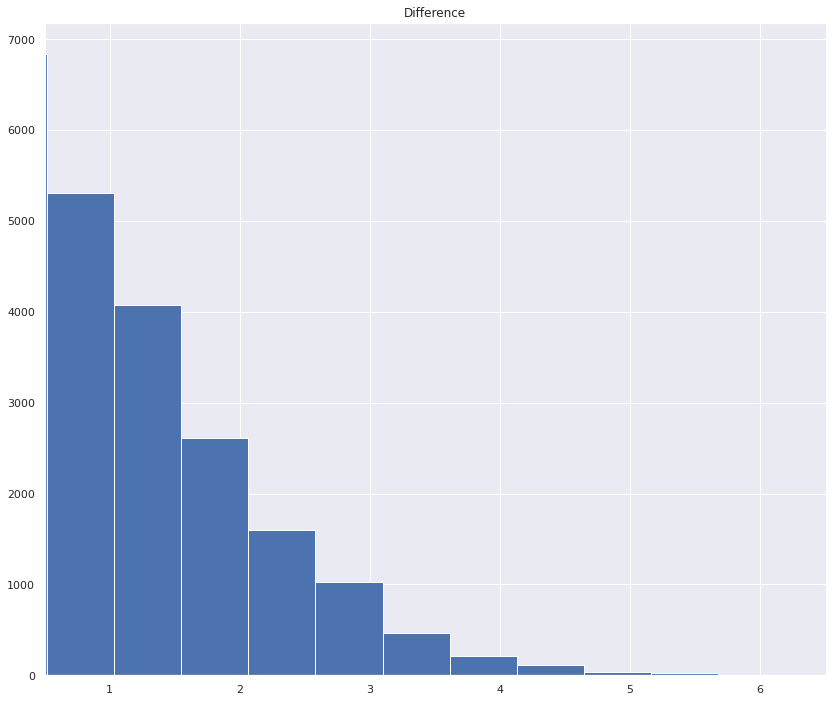

In [23]:
plt.figure(figsize=(14,12))
plt.hist(h.difference,bins=12)
plt.xlim(0.5,)
plt.title("Diff")